In [1]:
import pandas as pd
import numpy as np
from tsa.preprocessing import get_sample_info, tpm_normalization
from tsa.gpr import gpr
from tsa.gene_selection import score_normalization, plot_scores, best_n_genes
from tsa.tsa import get_cost_matrix, best_alignment_graph, plot_alignment
from tsa.utils import list2floats, inference_timeseries
from tsa.plotting import plot_alignments

In [6]:
filter_template_genes = True

new_gpr = False
timepoints_per_sample = 10

new_genes = False
n_genes = 500

In [3]:
# GPR input files
tpm_file = "data/GRCz11-TPM.tsv"
# tpm_file = "data/XT9.1-TPM.tsv"
# template_samples_file = "data/white_stage_samples.tsv"
template_samples_file = "data/white_mpf_samples.tsv"
# template_samples_file = "data/owensA1_mpf_samples.tsv"

# GPR output files
# gpr_inference_file = "data/white_stage_gpr.tsv"
# gpr_scores_file = "data/white_stage_score.tsv"
gpr_inference_file = "data/white_mpf_gpr.tsv"
gpr_scores_file = "data/white_mpf_score.tsv"
# gpr_inference_file = "data/owensA1_mpf_gpr.tsv"
# gpr_scores_file = "data/owensA1_mpf_score.tsv"

# gene selection
selected_genes_file = "data/white_genes.tsv"
# selected_genes_file = "data/owensA1_genes.tsv"

# GPR

In [4]:
# preprocessing
template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
sample_order, time2samples = get_sample_info(template_samples)

tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)
template_tpms = tpm_normalization(tpms, sample_order, minimum_value=5)

# filter genes BEFORE running GPR (optional)
if filter_template_genes:
    selected_genes = list(pd.read_csv(selected_genes_file, sep="\t")["gene"])
    template_tpms = template_tpms[template_tpms.index.isin(selected_genes)]

Genes with TPM below 5: 11063 of 32212 (34.0%)


In [5]:
# linear space
# extended_timepoints = list(np.round(np.linspace(min(time2samples), max(time2samples), 10), 2))

# n points per input
extended_timepoints = inference_timeseries(list(time2samples), timepoints_per_sample)

print(len(extended_timepoints))
print(extended_timepoints[0:4])

171
[0.0, 4.5, 9.0, 13.5]


In [7]:
if new_gpr:
    # GPR (slow)
    template_tpms_inf, gpr_scores = gpr(time2samples, template_tpms, extended_timepoints, plot=False, verbose=True, run_n=None)
    
    template_tpms_inf.to_csv(gpr_inference_file, sep="\t")
    gpr_scores.to_csv(gpr_scores_file, sep="\t")
else:
    template_tpms_inf = pd.read_csv(gpr_inference_file, sep="\t", index_col=0)
    gpr_scores = pd.read_csv(gpr_scores_file, sep="\t", index_col=0)
    
template_tpms_inf

,0.0,4.5,9.0,13.5,18.0,22.5,27.0,31.5,36.0,40.5,...,5904.0,6048.0,6192.0,6336.0,6480.0,6624.0,6768.0,6912.0,7056.0,7200.0
gene,,,,,,,,,,,,,,,,,,,,,
ENSDARG00000000212,2.057579,2.035741,2.009841,1.982234,1.955542,1.932449,1.915510,1.906942,1.908419,1.920836,...,8.673339,8.776724,8.861061,8.924029,8.963703,8.978491,8.967111,8.928613,8.862438,8.768519
ENSDARG00000001870,1.554896,1.609678,1.662250,1.711995,1.758282,1.800496,1.838069,1.870512,1.897464,1.918737,...,8.135755,8.221121,8.298150,8.364617,8.418162,8.456377,8.476906,8.477569,8.456500,8.412320
ENSDARG00000002165,4.578609,4.662496,4.713415,4.732882,4.723212,4.686916,4.626355,4.543603,4.440525,4.319032,...,3.220236,3.271762,3.304311,3.318652,3.315468,3.295164,3.257804,3.203171,3.130964,3.041142
ENSDARG00000002193,1.353266,1.359808,1.356369,1.343728,1.322961,1.295276,1.261898,1.224005,1.182689,1.138947,...,10.392293,10.374266,10.358154,10.340246,10.314746,10.274239,10.210242,10.113895,9.976876,9.792618
ENSDARG00000002445,0.836980,0.892979,0.947595,0.999417,1.046888,1.088381,1.122278,1.147072,1.161491,1.164659,...,1.681938,1.718599,1.759116,1.800931,1.841552,1.878573,1.909706,1.932856,1.946213,1.948409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSDARG00000115868,0.659894,0.771239,0.887280,1.004345,1.118110,1.223841,1.316615,1.391586,1.444306,1.471160,...,0.877227,0.897366,0.925329,0.958978,0.995829,1.033187,1.068276,1.098387,1.121053,1.134292
ENSDARG00000116570,1.900127,2.000766,2.094202,2.179112,2.254022,2.317176,2.366514,2.399771,2.414706,2.409525,...,0.079058,0.077534,0.074313,0.069613,0.063735,0.057020,0.049822,0.042486,0.035322,0.028592
ENSDARG00000116617,1.053917,1.097539,1.139642,1.179607,1.216757,1.250364,1.279654,1.303826,1.322061,1.333546,...,5.145059,5.117758,5.092338,5.067165,5.040439,5.010275,4.974781,4.932154,4.880791,4.819414


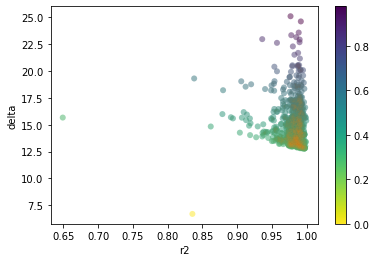

selected genes: 501


In [10]:
# gene selection (optional)
gpr_normscores = score_normalization(gpr_scores)
plot_scores(gpr_normscores, highlight_top_n=n_genes)

if new_genes:
    # save selected genes
    selected_genes = best_n_genes(gpr_normscores, n_genes=n_genes, to_file=selected_genes_file)
else:
    selected_genes = list(pd.read_csv(selected_genes_file, sep="\t")["gene"])
    
print("selected genes:", len(selected_genes))
# print(selected_genes[0:10])

# TSA

In [11]:
# TSA input files
# tpm_file = "data/GRCz11-TPM.tsv"
# template_samples_file = "data/white_stage_samples.tsv"
# template_samples_file = "data/white_mpf_samples.tsv"
# gpr_inference_file = "data/white_stage_gpr.tsv"
# selected_genes_file = "data/white_stage_selected_genes.tsv"

# query_samples_file = "data/white_stage_samples.tsv"
# query_samples_file = "data/levin_stage_samples.tsv"
# query_samples_file = "data/marletaz_stage_samples.tsv"
# query_samples_file = "data/white_mpf_samples.tsv"
query_samples_file = "data/levin_mpf_samples.tsv"
# query_samples_file = "data/marletaz_mpf_samples.tsv"

# TSA output files
# alignment_file = "data/white_stage_white_stage_mapping.tsv"
# alignment_file = "data/white_stage_levin_stage_mapping.tsv"
# alignment_file = "data/white_stage_marletaz_stage_mapping.tsv"
# alignment_file = "data/white_mpf_white_mpf_mapping.tsv"
alignment_file = "data/white_mpf_levin_mpf_mapping.tsv"
# alignment_file = "data/white_mpf_marletaz_mpf_mapping.tsv"
# alignment_file = "data/white_mpf_linear_white_mpf_mapping.tsv"
# alignment_file = "data/white_mpf_linear_levin_mpf_mapping.tsv"
# alignment_file = "data/white_mpf_linear_marletaz_mpf_mapping.tsv"

# query_samples_file = "data/owensA1_mpf_samples.tsv"
# alignment_file = "data/owensA1_mpf_owensA1_mpf_mapping.tsv"

# query_samples_file = "data/owensA2_mpf_samples.tsv"
# alignment_file = "data/owensA1_mpf_owensA2_mpf_mapping.tsv"

# query_samples_file = "data/owensB1_mpf_samples.tsv"
# alignment_file = "data/owensA1_mpf_owensB1_mpf_mapping.tsv"

# query_samples_file = "data/tanA_mpf_samples.tsv"
# alignment_file = "data/owensA1_mpf_tanA_mpf_mapping.tsv"

# query_samples_file = "data/tanB_mpf_samples.tsv"
# alignment_file = "data/owensA1_mpf_tanB_mpf_mapping.tsv"

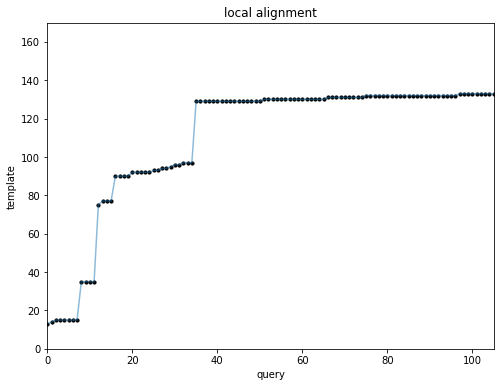

In [79]:
# preprocessing
query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
sample_order, time2samples = get_sample_info(query_samples)

tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)
query_tpms = tpm_normalization(tpms, sample_order)

# cost matrix
# selected_genes = list(pd.read_csv(selected_genes_file, sep="\t")["gene"])
# template_tpms_inf = pd.read_csv(gpr_inference_file, sep="\t", index_col=0)
cost_matrix = get_cost_matrix(template_tpms_inf, query_tpms, selected_genes, time2samples)

# LTSA
best_path, best_score = best_alignment_graph(cost_matrix)
plot_alignment(cost_matrix, best_path)

# mapping
query_time = list2floats(query_samples.time.unique())
extended_template_time = list2floats(template_tpms_inf.columns)
mapped = pd.DataFrame(data={
    "original_time": query_time,
    "inferred_time": [extended_template_time[i] for i in best_path],
})
# mapped.to_csv(alignment_file, sep="\t", index=False)  # noqa

In [12]:
# preprocessing
query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
sample_order, time2samples = get_sample_info(query_samples)

tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)
query_tpms = tpm_normalization(tpms, sample_order)
query_tpms = query_tpms[query_tpms.index.isin(selected_genes)]

In [133]:
import seaborn as sns
from scipy.spatial.distance import cdist

def get_cost_matrix(template_tpms, query_tpms, metric='euclidean'):
    template = template_tpms.to_numpy(dtype=np.float64)
    query = query_tpms.to_numpy(dtype=np.float64)
    cost_matrix = cdist(template.T, query.T, metric=metric).T  # pairwise distance matrix
    return cost_matrix

In [13]:
query_tpms.shape

(501, 106)

In [ ]:
t = pd.read_csv("data/white_mpf_white_mpf_mapping.tsv", sep="\t")
q = pd.read_csv("data/white_mpf_levin_mpf_metric_test_mapping.tsv", sep="\t")
template_tpms_inf = pd.read_csv("data/white_mpf_gpr.tsv", sep="\t", index_col=0)
extended_template_time = list2floats(template_tpms_inf.columns)

genes = template_tpms_inf.index.to_list()
gene = genes[100]

braycurtis


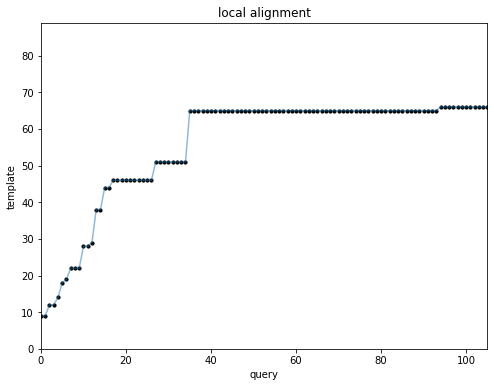

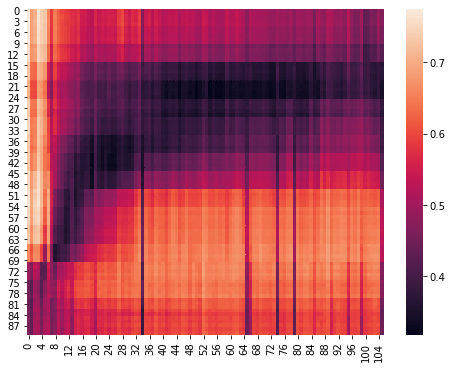

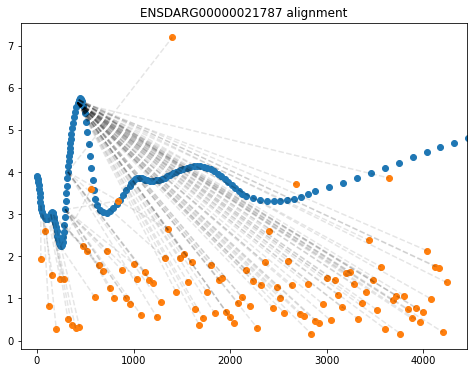

canberra


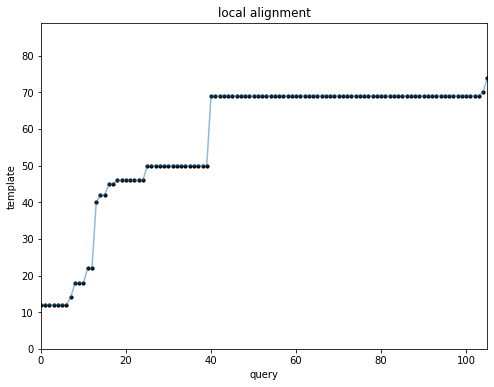

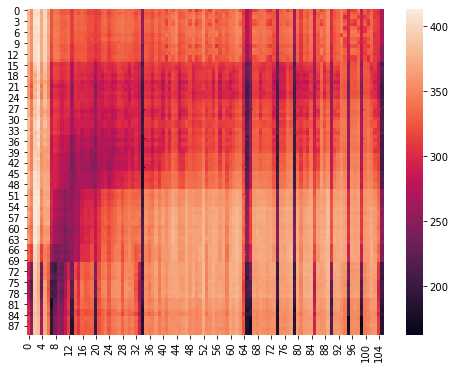

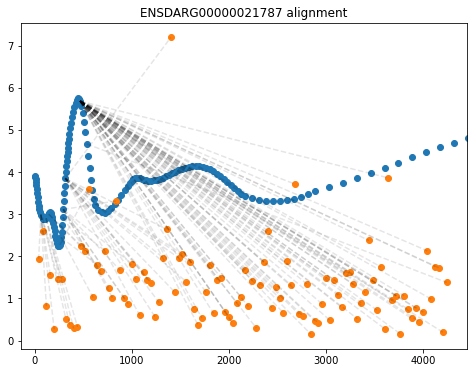

chebyshev


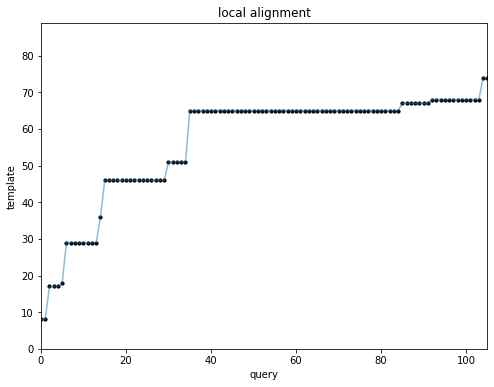

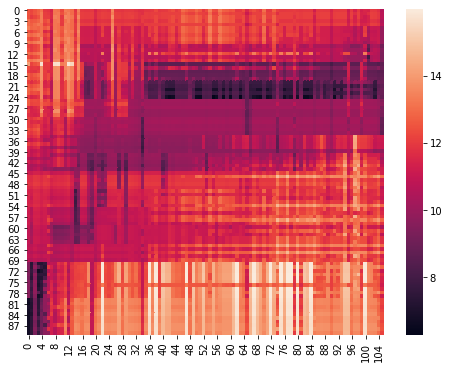

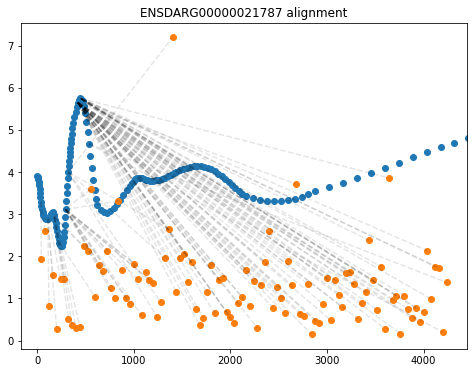

correlation


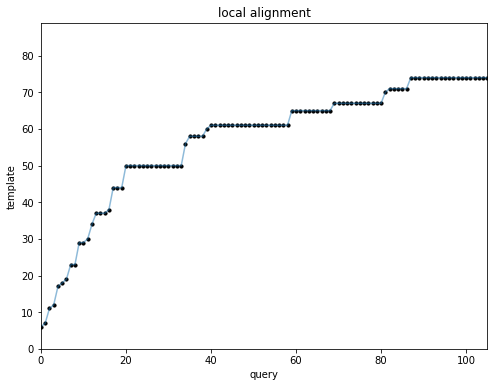

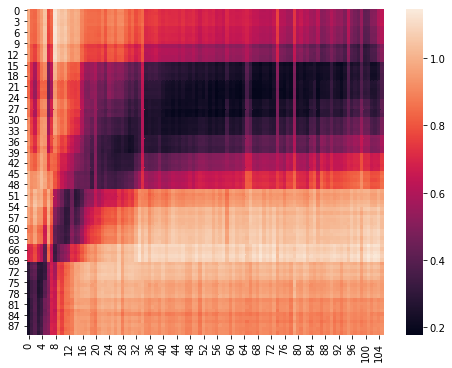

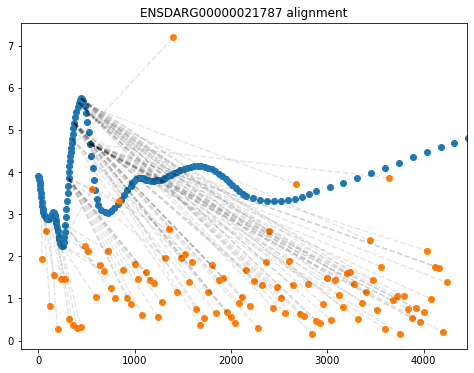

cosine


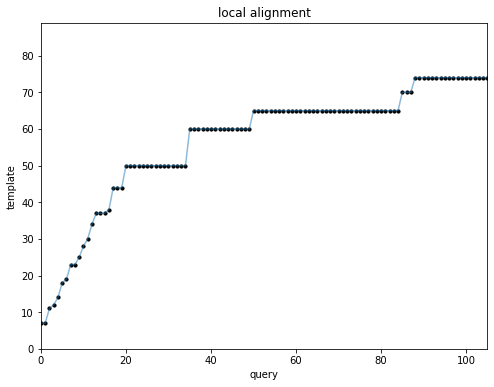

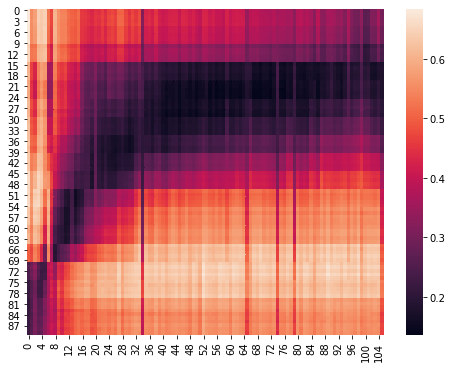

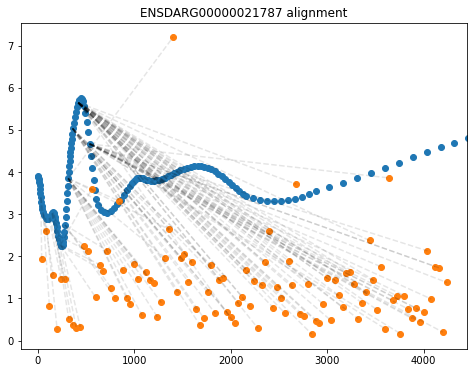

euclidean


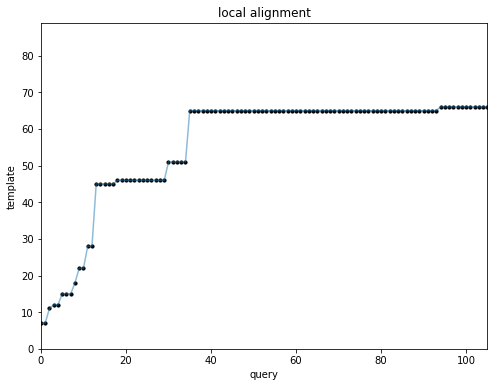

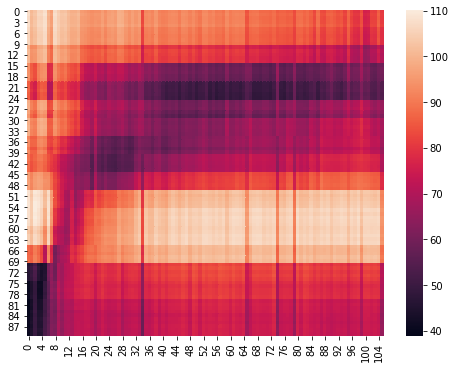

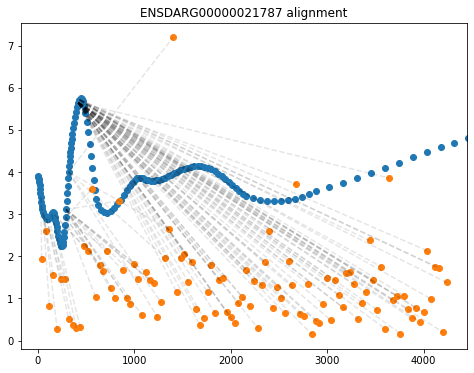

jensenshannon


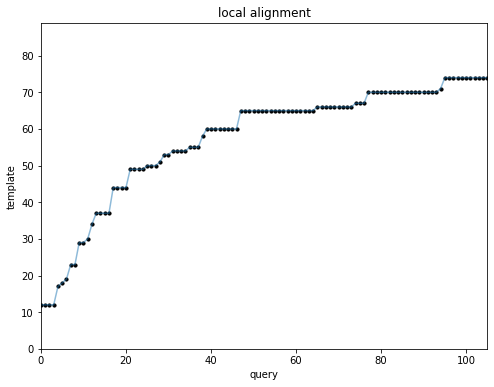

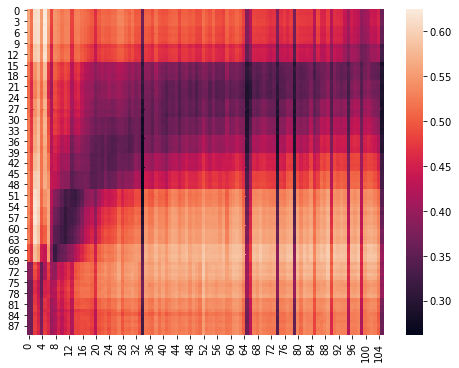

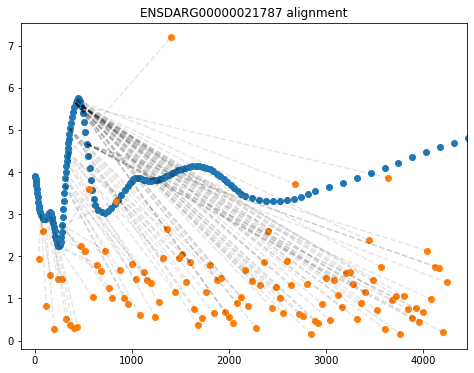

minkowski


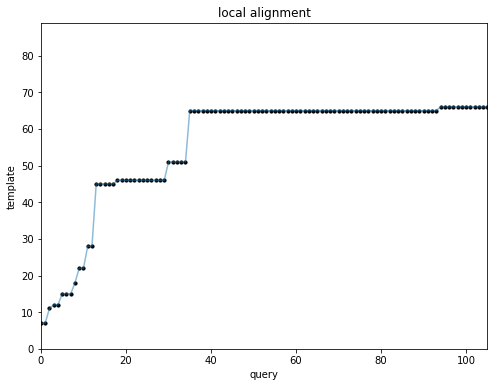

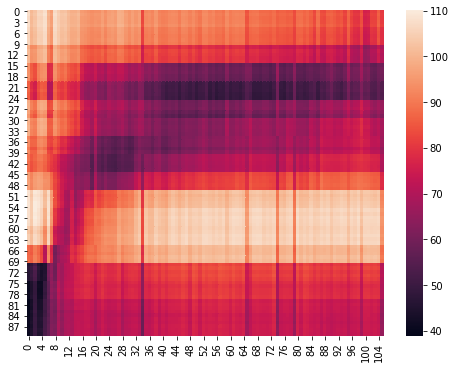

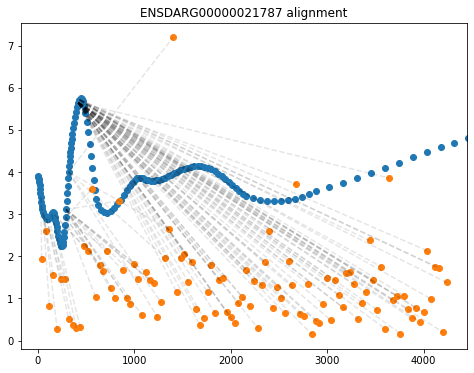

seuclidean


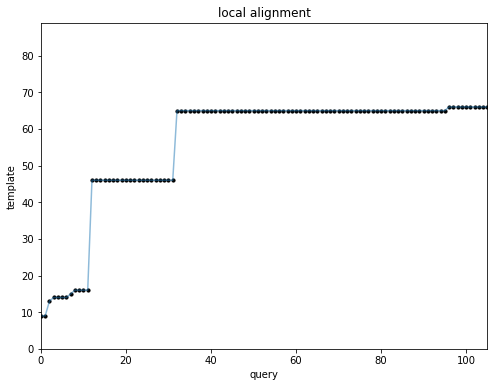

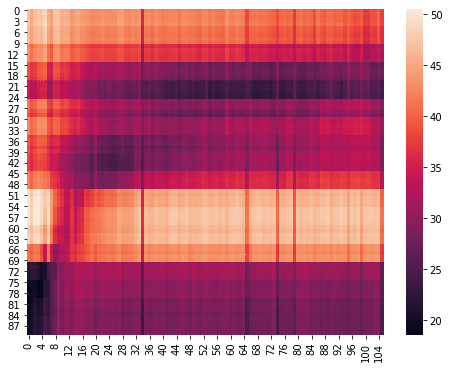

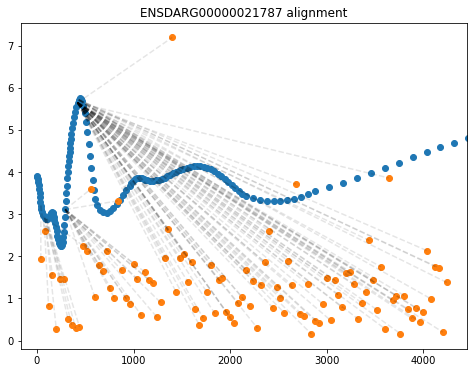

sqeuclidean


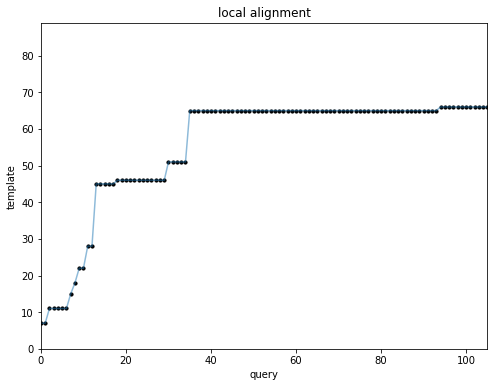

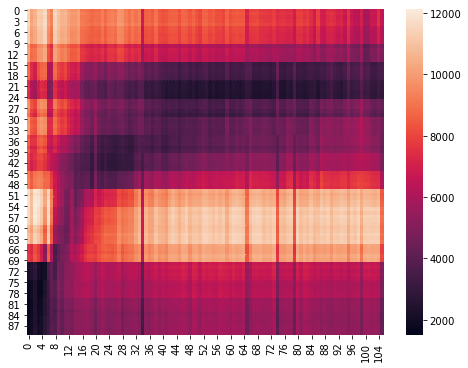

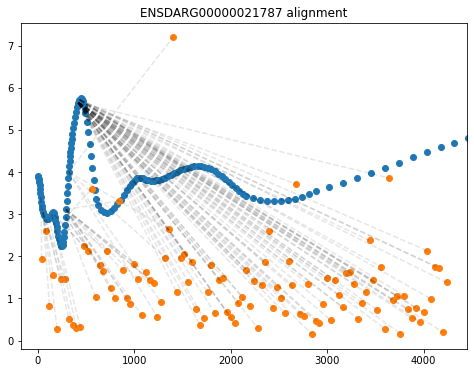

In [158]:
metrics = ["braycurtis", "canberra", "chebyshev", "cityblock", "correlation", "cosine", "dice", "euclidean", "hamming", "jaccard", "jensenshannon", "kulsinski", "mahalanobis", "matching", "minkowski", "rogerstanimoto", "russellrao", "seuclidean", "sokalmichener", "sokalsneath", "sqeuclidean", "wminkowski", "yule"]
metrics = ["braycurtis", "canberra", "chebyshev", "correlation", "cosine", "euclidean", "jensenshannon", "minkowski", "seuclidean", "sqeuclidean"]
for metric in metrics:
    print(metric)
    try:
        cost_matrix = get_cost_matrix(template_tpms, query_tpms, metric)#='euclidean')
    except:
        print("failed")
        continue

    # LTSA
    best_path, best_score = best_alignment_graph(cost_matrix)
    plot_alignment(cost_matrix, best_path)

    # heatmap, matrix flipped to go from bottom left to top right.
    sns.heatmap(cost_matrix[:,::-1].T)
    plt.show()
    
    # mapping
    query_time = list2floats(query_samples.time.unique())
    extended_template_time = list2floats(template_tpms_inf.columns)
    mapped = pd.DataFrame(data={
        "original_time": query_time,
        "inferred_time": [extended_template_time[i] for i in best_path],
    })
#     print(mapped)
    #mapped.to_csv("data/white_mpf_levin_mpf_metric_test_mapping.tsv", sep="\t", index=False)  # noqa
    
    # alignment
    #q = pd.read_csv("data/white_mpf_levin_mpf_metric_test_mapping.tsv", sep="\t")
    # q = mapped
    x1 = extended_template_time
    y1 = template_tpms_inf.loc[gene].to_list()

    x2 = mapped.original_time.to_list()
    y2 = query_tpms.loc[gene].to_list() 

    plt.scatter(x=x1, y=y1)
    plt.scatter(x=x2, y=y2)
    for n in range(len(x2)):
        m = best_path[n]
        plt.plot((x1[m], x2[n]), (y1[m], y2[n]), color = 'black', alpha=0.1, linestyle='--')

    # pretty stuff
    plt.title(f"{gene} alignment")
    start = x1[best_path[0]]
    end = max(x1[best_path[-1]], x2[-1])
    a_bit = (end - start) * 0.05
    plt.xlim(start - a_bit, end + a_bit)
    plt.show()

(-136.4, 4448.4)

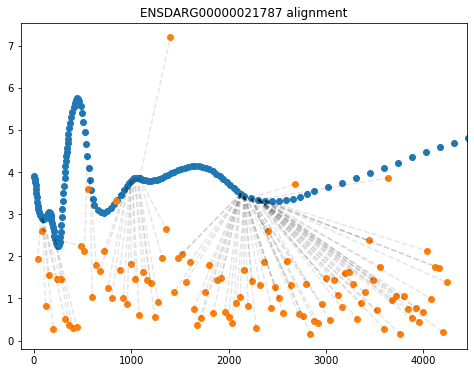

In [127]:
t = pd.read_csv("data/white_mpf_white_mpf_mapping.tsv", sep="\t")
q = pd.read_csv("data/white_mpf_levin_mpf_metric_test_mapping.tsv", sep="\t")
template_tpms_inf = pd.read_csv("data/white_mpf_gpr.tsv", sep="\t", index_col=0)
extended_template_time = list2floats(template_tpms_inf.columns)

genes = template_tpms_inf.index.to_list()
gene = genes[100]

# x1 = t.original_time.to_list()
# y1 = template_tpms.loc[gene].to_list()[::5]  # 5 replciates
x1 = extended_template_time
y1 = template_tpms_inf.loc[gene].to_list()

x2 = q.original_time.to_list()
y2 = query_tpms.loc[gene].to_list() 

plt.scatter(x=x1, y=y1)
plt.scatter(x=x2, y=y2)
for n in range(len(x2)):
    m = best_path[n]
    plt.plot((x1[m], x2[n]), (y1[m], y2[n]), color = 'black', alpha=0.1, linestyle='--')
    
# pretty stuff
plt.title(f"{gene} alignment")
start = x1[best_path[0]]
end = max(x1[best_path[-1]], x2[-1])
a_bit = (end - start) * 0.05
plt.xlim(start - a_bit, end + a_bit)



In [147]:
# gene = selected_genes[0]
# t = template_tpms_inf.loc[gene]
# q = query_tpms.loc[gene]
# a = [t.to_list()[i] for i in best_path]

# plt.scatter(x=range(len(t)), y=t)
# plt.scatter(x=best_path, y=a)
# plt.scatter(x=best_path, y=q)
# plt.title(f"{gene} alignment")

# for n in range(len(q)):
#     m = best_path[n]
#     plt.plot((m, m), (a[n], q[n]), color = 'black', alpha=0.1, linestyle='--')

# Timeline

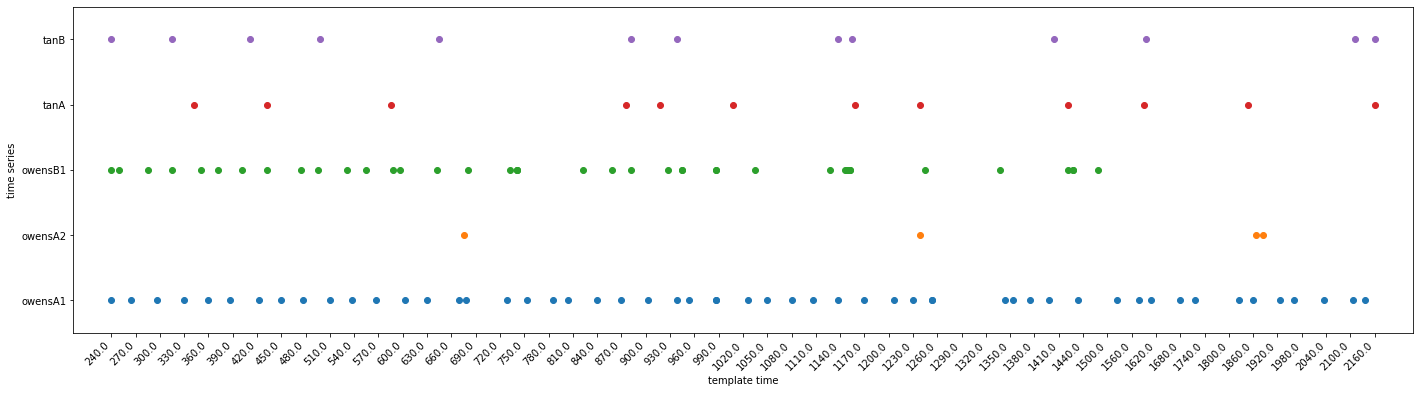

In [43]:
# Timeline input files
# template_samples_file = "data/white_stage_samples.tsv"
# template_samples_file = "data/white_mpf_samples.tsv"
# gpr_inference_file = "data/white_mpf_gpr.tsv"

# alignment_files = {
#     "white": "data/white_stage_white_stage_mapping.tsv",
#     "levin": "data/white_stage_levin_stage_mapping.tsv",
#     "marletaz": "data/white_stage_marletaz_stage_mapping.tsv",
# }
# alignment_files = {
#     "white": "data/white_mpf_white_mpf_mapping.tsv",
#     "levin": "data/white_mpf_levin_mpf_mapping.tsv",
#     "marletaz": "data/white_mpf_marletaz_mpf_mapping.tsv",
# }
# alignment_files = {
#     "white": "data/white_mpf_1000_white_mpf_mapping.tsv",
#     "levin": "data/white_mpf_1000_levin_mpf_mapping.tsv",
#     "marletaz": "data/white_mpf_1000_marletaz_mpf_mapping.tsv",
# }
alignment_files = {
    "owensA1": "data/owensA1_mpf_owensA1_mpf_mapping.tsv",
    "owensA2": "data/owensA1_mpf_owensA2_mpf_mapping.tsv",
    "owensB1": "data/owensA1_mpf_owensB1_mpf_mapping.tsv",
    "tanA": "data/owensA1_mpf_tanA_mpf_mapping.tsv",
    "tanB": "data/owensA1_mpf_tanB_mpf_mapping.tsv",
}

####################################################

# x axis
# template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
# template_tpms_inf = pd.read_csv(gpr_inference_file, sep="\t", index_col=0)

template_time = list2floats(template_samples.time.unique())
extended_template_time = list2floats(template_tpms_inf.columns)
# extended_timepoints = inference_timeseries(template_time, timepoints_per_sample)
plot_alignments(template_time, extended_template_time, alignment_files)

In [51]:
samples = pd.read_csv("/bank/experiments/2020-07/s2s_batch_corr2/samples.tsv", sep="\t", index_col=0)

# fix errors in mpf and hpf columns
samples.loc[samples.index == "GSM919943", "mpf"] = 240
samples.loc[samples.index == "GSM919943", "hpf"] = 4.0

samples.loc[samples.index == "GSM919944", "mpf"] = 300
samples.loc[samples.index == "GSM919944", "hpf"] = 5.0

samples.loc[samples.index == "GSM919922", "mpf"] = 300
samples.loc[samples.index == "GSM919922", "hpf"] = 5.0

df = samples[samples["batch"] == 'owens_clutchA_polyA_run1']
df = df[["stage", "mpf"]].reset_index(drop=True)
df = df.sort_values("mpf", ascending=True)

stage2time = {}
for stage in df.stage.unique():
    stage2time[stage] = df[df["stage"] == stage]["mpf"].mean()
    
list(stage2time.values())

[240.0,
 315.0,
 420.0,
 480.0,
 555.0,
 660.0,
 750.0,
 825.0,
 870.0,
 900.0,
 930.0,
 960.0,
 1005.0,
 1065.0,
 1110.0,
 1185.0,
 1290.0,
 1380.0,
 1500.0,
 1650.0,
 1740.0,
 1800.0,
 1890.0,
 2040.0,
 2160.0]

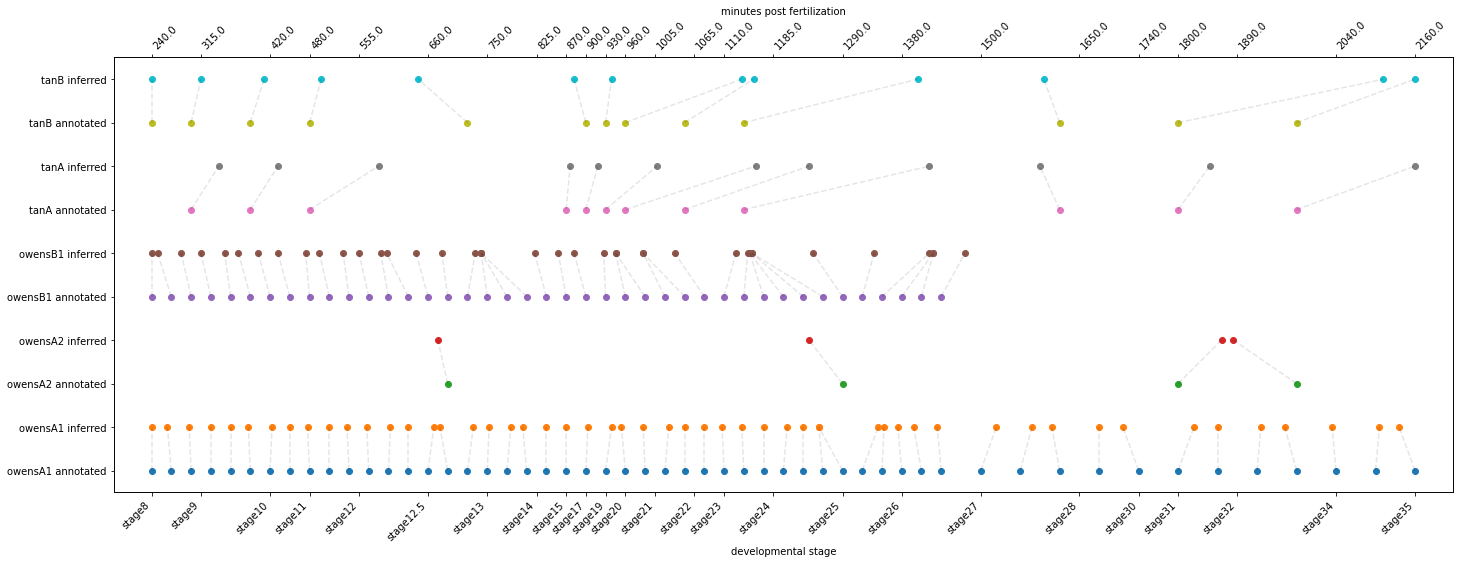

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# xenopus timeline (OwensA1 (with average time per stage))
all_mpf = [
    240.0,
    315.0,
    420.0,
    480.0,
    555.0,
    660.0,
    750.0,
    825.0,
    870.0,
    900.0,
    930.0,
    960.0,
    1005.0,
    1065.0,
    1110.0,
    1185.0,
    1290.0,
    1380.0,
    1500.0,
    1650.0,
    1740.0,
    1800.0,
    1890.0,
    2040.0,
    2160.0,
]
all_stages = [
    'stage8',
    'stage9',
    'stage10',
    'stage11',
    'stage12',
    'stage12.5',
    'stage13',
    'stage14',
    'stage15',
    'stage17',
    'stage19',
    'stage20',
    'stage21',
    'stage22',
    'stage23',
    'stage24',
    'stage25',
    'stage26',
    'stage27',
    'stage28',
    'stage30',
    'stage31',
    'stage32',
    'stage34',
    'stage35',
]

#########################################

# query alignments
alignment_files = {
    "owensA1": "data/owensA1_mpf_owensA1_mpf_mapping.tsv",
    "owensA2": "data/owensA1_mpf_owensA2_mpf_mapping.tsv",
    "owensB1": "data/owensA1_mpf_owensB1_mpf_mapping.tsv",
    "tanA": "data/owensA1_mpf_tanA_mpf_mapping.tsv",
    "tanB": "data/owensA1_mpf_tanB_mpf_mapping.tsv",
}

# output plot
plot_file = "data/alignment_owensA1_mpf.pdf"

#########################################

plt.rcParams['figure.figsize'] = [24, 8]
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

n = 0
ylabels = []
for series in alignment_files:
    df = pd.read_csv(alignment_files[series], sep="\t")
    x1 = df["original_time"]
    x2 = df["inferred_time"]
    plt.scatter(x=x1, y=np.zeros_like(x1) + n)
    n += 1
    plt.scatter(x=x2, y=np.zeros_like(x2) + n)
    n += 1
    ylabels.extend([f"{series} annotated", f"{series} inferred"])
    
    matches = zip(x1, x2)
    for i, j in matches:
        plt.plot((i, j), (n-2, n-1), color = 'black', alpha=0.1, linestyle='--')

# plot shape
x_axis = all_mpf
x_labels1 = all_stages
x_labels2 = all_mpf

x_range = max(x_axis) - min(x_axis)
plt.yticks(list(range(n)), ylabels)
plt.ylim(-0.5, n - 0.5)
plt.ylabel("time series")

total_time = max(x_axis) - min(x_axis)
plt.xlim(min(x_axis) - x_range * 0.03, max(x_axis) + x_range * 0.03)
ax1.set_xlim(ax2.get_xlim())  # for some reason ax2 has the limits we need, but not ax1(?)
# ax1.grid(True, "major", axis="x", alpha=0.7,ls=':',)

ax1.set_xticks(x_axis)
ax1.set_xticklabels(x_labels1, rotation=45, ha="right")
ax1.set_xlabel("developmental stage")

ax2.set_xticks(x_axis)
ax2.set_xticklabels(x_labels2, rotation=45, ha="left")
ax2.set_xlabel("minutes post fertilization")

plt.savefig(plot_file)
plt.show()

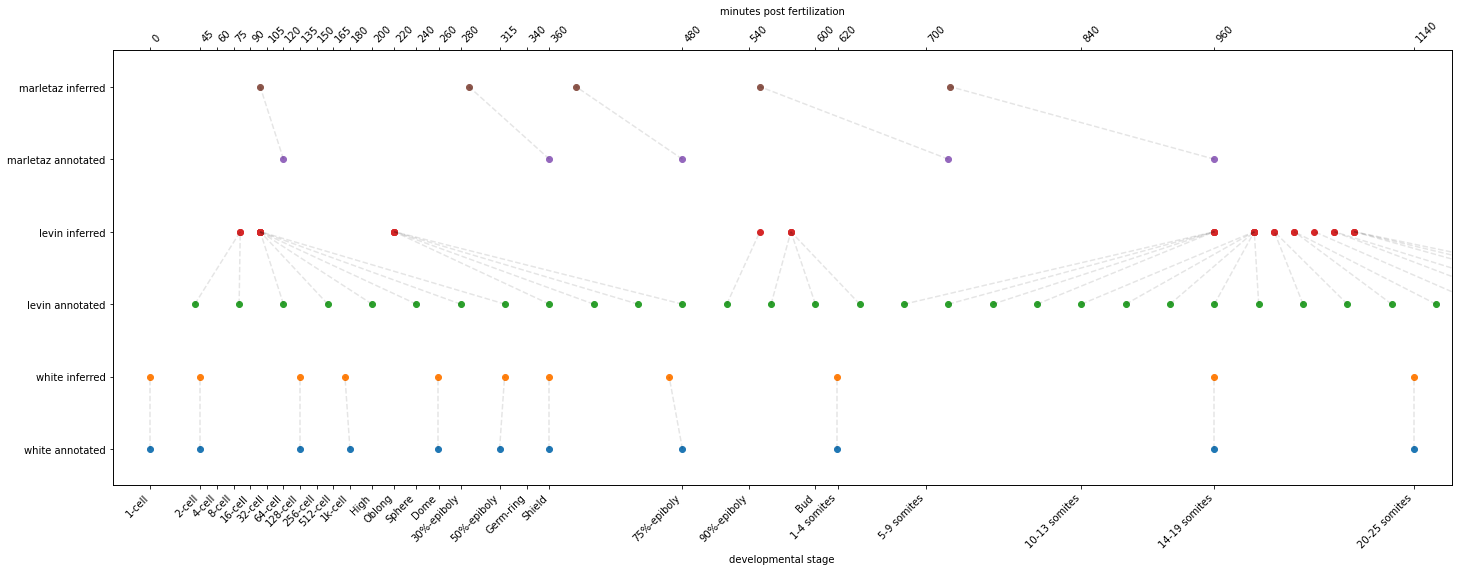

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tsa.utils import inference_timeseries


# universal zebrafish time axis (from ZFIN)
all_mpf = [
    0,
    45,
    60,
    75,
    90,
    105,
    120,
    135,
    150,
    165,
    180,
    200,
    220,
    240,
    260,
    280,
    315,
    340,
    360,
    480,
    540,
    600,
    620,
    700,
    840,
    960,
    1140,
    1320,
    1440,
    1800,
    2160,
    2520,
    2880,
    3600,
    4320,
    5760,
    7200,
    8640,
    10080,
    20160,
    30240,
    43200,
    64800,
][:-6]
all_stages = [
    "1-cell",
    "2-cell",
    "4-cell",
    "8-cell",
    "16-cell",
    "32-cell",
    "64-cell",
    "128-cell",
    "256-cell",
    "512-cell",
    "1k-cell",
    "High",
    "Oblong",
    "Sphere",
    "Dome",
    "30%-epiboly",
    "50%-epiboly",
    "Germ-ring",
    "Shield",
    "75%-epiboly",
    "90%-epiboly",
    "Bud",
    "1-4 somites",
    "5-9 somites",
    "10-13 somites",
    "14-19 somites",
    "20-25 somites",
    "26+ somites",
    "Prim-5",
    "Prim-15",
    "Prim-25",
    "High-pec",
    "Long-pec",
    "Pec-fin",
    "Protruding-mouth",
    "Day 4",
    "Day 5",
    "Day 6",
    "Days 7-13",
    "Days 14-20",
    "Days 21-29",
    "Days 30-44",
    "Days 45-89",
][:-6]


#########################################


# query alignments
# alignment_files = {
#     "white": "data/white_stage_white_stage_mapping.tsv",
#     "levin": "data/white_stage_levin_stage_mapping.tsv",
#     "marletaz": "data/white_stage_marletaz_stage_mapping.tsv",
# }
alignment_files = {
    "white": "data/white_mpf_white_mpf_mapping.tsv",
    "levin": "data/white_mpf_levin_mpf_mapping.tsv",
    "marletaz": "data/white_mpf_marletaz_mpf_mapping.tsv",
}
# alignment_files = {
#     "white": "data/white_mpf_linear_white_mpf_mapping.tsv",
#     "levin": "data/white_mpf_linear_levin_mpf_mapping.tsv",
#     "marletaz": "data/white_mpf_linear_marletaz_mpf_mapping.tsv",
# }

# output plot
plot_file = "data/alignment_white_mpf.pdf"

fig = plt.figure(1,figsize = [24, 8])
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

n = 0
ylabels = []
for series in alignment_files:
    df = pd.read_csv(alignment_files[series], sep="\t")
    x1 = df["original_time"]
    x2 = df["inferred_time"]
    plt.scatter(x=x1, y=np.zeros_like(x1) + n)
    n += 1
    plt.scatter(x=x2, y=np.zeros_like(x2) + n)
    n += 1
    ylabels.extend([f"{series} annotated", f"{series} inferred"])
    
    matches = zip(x1, x2)
    for i, j in matches:
        plt.plot((i, j), (n-2, n-1), color = 'black', alpha=0.1, linestyle='--')

# plot shape
x_axis = all_mpf[:-10]
x_labels1 = all_stages[:-10]
x_labels2 = all_mpf[:-10]
x_range = max(x_axis) - min(x_axis)
plt.yticks(list(range(n)), ylabels)
plt.ylim(-0.5, n - 0.5)
plt.ylabel("time series")

total_time = max(x_axis) - min(x_axis)
plt.xlim(min(x_axis) - x_range * 0.03, max(x_axis) + x_range * 0.03)
ax1.set_xlim(ax2.get_xlim())  # for some reason ax2 has the limits we need, but not ax1(?)

ax1.set_xticks(x_axis)
ax1.set_xticklabels(x_labels1, rotation=45, ha="right")
ax1.set_xlabel("developmental stage")

ax2.set_xticks(x_axis)
ax2.set_xticklabels(x_labels2, rotation=45, ha="left")
ax2.set_xlabel("minutes post fertilization")

plt.savefig(plot_file)
plt.show()

In [80]:
print(ax1.get_xlim())
print(ax2.get_xlim())

(0.0, 1140.0)
(-34.199999999999996, 1174.2)


In [ ]:
# # template time
# template_samples_file = "data/white_stage_samples.tsv"
# timepoints_per_sample = 10

# # query alignments
# alignments = {
#     "white": "data/white_stage_white_stage_mapping.tsv",
#     "levin": "data/white_stage_levin_stage_mapping.tsv",
#     "marletaz": "data/white_stage_marletaz_stage_mapping.tsv",
# }

# # output plot
# plot_file = "data/alignment_white_stage.pdf"



# template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
# template_time = list(template_samples.time.unique())
# extended_template_time = inference_timeseries(template_time, timepoints_per_sample)

# ext_time_axis = pd.DataFrame({
#     "ext_all_mpf": inference_timeseries(all_mpf, timepoints_per_sample),
#     "ext_all_stages": inference_timeseries(all_stages, timepoints_per_sample),
# })

# plt.rcParams['figure.figsize'] = [24, 8]
# fig = plt.figure(1)
# ax1 = fig.add_subplot(111)
# ax2 = ax1.twiny()

# n = 0
# ylabels = []
# for series in alignments:
#     df = pd.read_csv(alignments[series], sep="\t")

#     x1 = df["original_time"]
#     if df["original_time"].dtype == "O":
#         cv = ext_time_axis.merge(df, left_on="ext_all_stages", right_on="original_time", how="right")
#         x1 = cv["ext_all_mpf"].to_list()
#     plt.scatter(x=x1, y=np.zeros_like(x1) + n)
#     n += 1

#     x2 = df["inferred_time"]
#     if df["inferred_time"].dtype == "O":
#         cv = ext_time_axis.merge(df, left_on="ext_all_stages", right_on="inferred_time", how="right")
#         x2 = cv["ext_all_mpf"].to_list()
#     plt.scatter(x=x2, y=np.zeros_like(x2) + n)
#     n += 1
#     ylabels.extend([f"{series} annotated", f"{series} inferred"])

# # plot shape
# x_axis = all_mpf[:-2]
# x_labels1 = all_stages[:-2]
# x_labels2 = all_mpf[:-2]
# x_range = max(x_axis) - min(x_axis)
# plt.yticks(list(range(n)), ylabels)
# plt.ylim(-0.5, n - 0.5)
# plt.ylabel("time series")

# # total_time = max(x_axis) - min(x_axis)
# # plt.xlim(min(x_axis), max(x_axis))
# plt.xlim(min(x_axis) - x_range * 0.03, max(x_axis) + x_range * 0.03)
# # plt.ylim(-0.5, 2.5)

# ax1.set_xticks(x_axis)
# ax1.set_xticklabels(x_labels1, rotation=45, ha="right")
# ax1.set_xlabel("developmental stage")

# ax2.set_xticks(x_axis)
# ax2.set_xticklabels(x_labels2, rotation=45, ha="left")
# ax2.set_xlabel("minutes post fertilization")

# plt.savefig(plot_file)
# plt.show()